# 6. Asign taxonomy to nanopore reads - SILVA db

In [1]:
library(tidyverse) 
library(dplyr)
library(ggplot2)
library(ggpubr)
library(forcats)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
print("Working directory before:")
getwd()

setwd("~/Documents/Collaborations/mangrove/analyses_R") # changing work directory to data 
print("Working directory after:")
getwd()

[1] "Working directory before:"


[1] "/home/strawberry/Documents/Collaborations/mangrove/github"

[1] "Working directory after:"


[1] "/home/strawberry/Documents/Collaborations/mangrove/analyses_R"

In [3]:
# Loading reference file 
SILVATaxID <- read.csv("./silva_taxonomy.csv", h=T)
SILVATaxID$id <- gsub("\\..*", "", SILVATaxID$id) # Clean the 'id' column (remove everything after the first dot)
print(head(SILVATaxID))

# Loading metadata file (read counts before quality check, should be replaced)
metadata <- read.delim("./metadata_nreads.tsv", h=T) 
read_counts_chopper <- read.delim("./read_counts_chopper", h=T)
print(head(read_counts_chopper))

## Replace nreads value to represent only reads retained after filtering
metadata$Number_Reads <- read_counts_chopper$filt_reads[
  match(metadata$ID, read_counts_chopper$ID_Sample)
]

print(head(metadata))

        id  Kingdom         Phylum               Class            Order
1 AB000393 Bacteria Pseudomonadota Gammaproteobacteria Enterobacterales
2 AB000480 Bacteria Pseudomonadota Alphaproteobacteria Rhodospirillales
3 AB001783 Bacteria    Chlamydiota          Chlamydiia     Chlamydiales
4 FZ423313 Bacteria      Bacillota             Bacilli       Bacillales
5 HG529990 Bacteria   Bacteroidota         Bacteroidia     Cytophagales
6 AB001778 Bacteria    Chlamydiota          Chlamydiia     Chlamydiales
             Family             Genus                      Species
1      Vibrionaceae            Vibrio           Vibrio halioticoli
2 Rhodospirillaceae Insolitispirillum Insolitispirillum peregrinum
3     Chlamydiaceae         Chlamydia            Chlamydia abortus
4       Bacillaceae     Anoxybacillus                 unidentified
5 Cyclobacteriaceae      Algoriphagus        Algoriphagus sp. AK58
6     Chlamydiaceae         Chlamydia           Chlamydia psittaci
      ID_Sample raw_reads f

In [6]:
# Make a repository with kma output
fragfiles <- list.files("./", pattern = ".frag$")
fragfiles

[1] "Sample-ID1-A1_filtered_kma.frag" "Sample-ID2-A2_filtered_kma.frag"
[3] "Sample-ID3-A3_filtered_kma.frag" "Sample-ID4-A4_filtered_kma.frag"
[5] "Sample-ID5-B1_filtered_kma.frag" "Sample-ID6-B2_filtered_kma.frag"
[7] "Sample-ID7-B3_filtered_kma.frag" "Sample-ID8-B4_filtered_kma.frag"

In [7]:
# Start with an empty dataframe
dfall <- NULL  

for(i in 1:length(fragfiles)){
    
# Load the .frag file
tab <- read.delim(fragfiles[i], h = FALSE)
# print(head(tab))

# Extract per-read best hit info
readID <- sub(" .*", "", tab$V7) # extract read ID
template_id <- gsub("\\..*", "", gsub("'", "", tab$V6)) # extract template ID without version
# head(readID)
# head(template_id)

# Build per-read hit table
readhits <- data.frame(readID, template_id, stringsAsFactors = FALSE)
# print(head(readhits))
      
# Remove duplicated reads (keeping only first hit per read)
readhits_unique <- readhits[!duplicated(readhits$readID), ]
# print(head(readhits_unique))

# Count number of hits per template
template_counts <- as.data.frame(table(readhits_unique$template_id))
colnames(template_counts) <- c("id", "count")
# print(head(template_counts))

# Merge with SILVA taxonomy
template_tax <- merge(template_counts, SILVATaxID, by = "id")

# Add sample ID (from file name — adjust as needed)
ID_Sample <- gsub("_filtered_kma.frag$", "", basename(fragfiles[i]))
template_tax$ID_Sample <- ID_Sample
    
# Add total aligned reads and calculate relative abundance
template_tax$total_aligned <- nrow(readhits_unique)
template_tax$RelativeAbundance <- template_tax$count / template_tax$total_aligned * 100
# head(template_tax)

# Merge with metadata and calculate alignment efficiency
template_tax_merge <- merge(template_tax, metadata, by.x = "ID_Sample", by.y = "ID")
template_tax_merge$AlignmentEfficiency <- template_tax_merge$total_aligned / template_tax_merge$Number_Reads * 100
# head(template_tax_merge)

# Optional: store in cumulative df
dfall <- rbind(dfall, template_tax_merge)
}

In [8]:
colnames(dfall)

[1] "ID_Sample"           "id"                  "count"              
 [4] "Kingdom"             "Phylum"              "Class"              
 [7] "Order"               "Family"              "Genus"              
[10] "Species"             "total_aligned"       "RelativeAbundance"  
[13] "ID_Sample.y"         "Mangrove"            "Collection_month"   
[16] "pH"                  "OM"                  "P"                  
[19] "Ca"                  "Mg"                  "K"                  
[22] "H.Al"                "SB"                  "CTC"                
[25] "V."                  "Number_Reads"        "AlignmentEfficiency"

In [9]:
print("Relative Abundance:")
print(summary(dfall$RelativeAbundance))

print("Alignment Efficency:")
print(summary(dfall$AlignmentEfficiency))

[1] "Relative Abundance:"
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.03463  0.06124  0.08006  0.11038  0.09124 17.55594 
[1] "Alignment Efficency:"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  72.90   74.08   96.65   90.99   97.21   97.85 


In [10]:
# Group samples and calculate annotation efficiency
AlignmentEfficiency_mangrove <- dfall %>%
  group_by(Mangrove) %>%
  summarise(mean_AlignmentEfficiency = mean(AlignmentEfficiency, na.rm = TRUE),
            sd_AlignmentEfficiency = sd(AlignmentEfficiency, na.rm = TRUE))
print(AlignmentEfficiency_mangrove) 

# A tibble: 2 × 3
  Mangrove   mean_AlignmentEfficiency sd_AlignmentEfficiency
  <chr>                         <dbl>                  <dbl>
1 Araçá                          89.6                  10.8 
2 Colhereiro                     92.4                   9.38


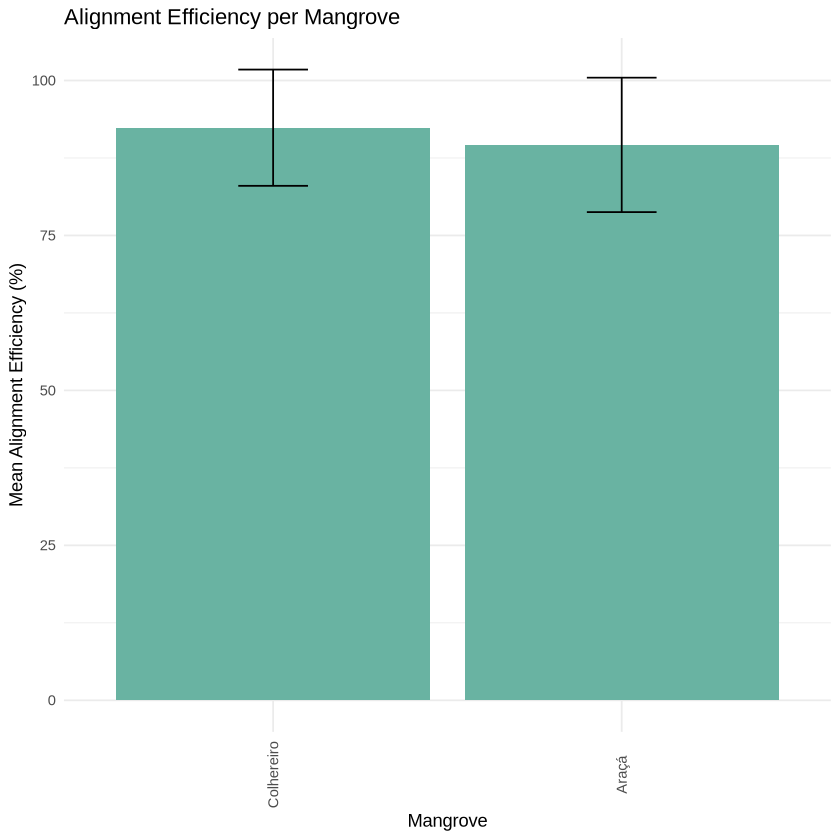

In [11]:
# Plot the frequence alignment distribution across groups
freqalignment_A <- ggplot(AlignmentEfficiency_mangrove, 
       aes(x = fct_reorder(Mangrove, -mean_AlignmentEfficiency), y = mean_AlignmentEfficiency)) +
  geom_bar(stat = "identity", fill = "#69b3a2") +
  geom_errorbar(aes(ymin = mean_AlignmentEfficiency - sd_AlignmentEfficiency,
                    ymax = mean_AlignmentEfficiency + sd_AlignmentEfficiency),
                width = 0.2) +
  theme_minimal() +
  labs(title = "Alignment Efficiency per Mangrove",
       y = "Mean Alignment Efficiency (%)",
       x = "Mangrove") +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5))
freqalignment_A


In [12]:
metadata <- metadata %>%
  select(-ID_Sample) %>%       # Remove the original ID_Sample column
  rename(ID_Sample = ID)       # Rename ID to ID_Sample

In [13]:
head(metadata)

,ID_Sample,Mangrove,Collection_month,pH,OM,P,Ca,Mg,K,H.Al,SB,CTC,V.,Number_Reads
,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<int>
1,Sample-ID1-A1,Araçá,September,7.3,10,24,58,56,12.6,9,126.6,135,94,1134
2,Sample-ID2-A2,Araçá,September,7.3,10,24,58,56,12.6,9,126.6,135,94,2971
3,Sample-ID3-A3,Araçá,September,7.3,10,24,58,56,12.6,9,126.6,135,94,1882
4,Sample-ID4-A4,Araçá,September,7.3,10,24,58,56,12.6,9,126.6,135,94,965
5,Sample-ID5-B1,Colhereiro,October,7.8,47,33,122,133,26.4,9,281.4,289,97,1686
6,Sample-ID6-B2,Colhereiro,October,7.8,47,33,122,133,26.4,9,281.4,289,97,2375


In [14]:
write.table(dfall, "ReadCounts_TaxAnnotation_SILVA.tsv", quote = F, sep = "\t", row.names = F)
write.table(metadata, "metadata_full_clean.tsv", quote = F, sep = "\t", row.names = F)